# Imports

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Get Data

In [2]:
(X_train, y_train), (X_test,y_test) = tf.keras.datasets.imdb.load_data(seed=0)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
X_train.shape,X_test.shape

((25000,), (25000,))

In [4]:
first_review = X_train[0]
second_review = X_train[1]

In [5]:
len(first_review),len(second_review) # review lengths vary

(417, 217)

Take a look at the data.

In [6]:
y_test

array([0, 1, 0, ..., 1, 1, 1])

In [7]:
first_review[:10] # First 9 words of the first review. Words in a review are replaced with integers.

[1, 4078, 13406, 9, 448, 725, 4, 13406, 241, 22150]

In [8]:
max_n = float('-inf')
for review in X_train:
  max_n = max(max_n, len(review))
print('Max number of words in a review :',max_n - 1) # ignore start of sequence token

Max number of words in a review : 2493


Pad reviews with trailing zeros.

In [9]:
X_train_padded = np.zeros(shape=(X_train.shape[0],max_n),dtype='int64')
for i in range(X_train_padded.shape[0]):
  review_i = X_train[i]
  X_train_padded[i,:len(review_i)] = review_i

In [10]:
X_train_padded

array([[    1,  4078, 13406, ...,     0,     0,     0],
       [    1,    25,   128, ...,     0,     0,     0],
       [    1,    14,     9, ...,     0,     0,     0],
       ...,
       [    1,    13,    28, ...,     0,     0,     0],
       [    1,     6,   768, ...,     0,     0,     0],
       [    1,  1945,    13, ...,     0,     0,     0]])

In [11]:
X_test_padded = np.zeros(shape=(X_test.shape[0],max_n),dtype='int64')
for i in range(X_test_padded.shape[0]):
  review_i = X_test[i]
  X_test_padded[i,:len(review_i)] = review_i

Remove start of sequence token from training and test data set, since it is not needed and can slow down training.

In [12]:
X_train_preprocessed = np.delete(X_train_padded,0,1)
X_train_preprocessed

array([[ 4078, 13406,     9, ...,     0,     0,     0],
       [   25,   128,    67, ...,     0,     0,     0],
       [   14,     9,    31, ...,     0,     0,     0],
       ...,
       [   13,    28,   610, ...,     0,     0,     0],
       [    6,   768,     7, ...,     0,     0,     0],
       [ 1945,    13,    67, ...,     0,     0,     0]])

In [13]:
X_test_preprocessed = np.delete(X_test_padded,0,1)

# Explore Data

In [14]:
pd.Series(y_train).info() # no missing values

<class 'pandas.core.series.Series'>
RangeIndex: 25000 entries, 0 to 24999
Series name: None
Non-Null Count  Dtype
--------------  -----
25000 non-null  int64
dtypes: int64(1)
memory usage: 195.4 KB


Visualize target distribution. The labels are balanced.

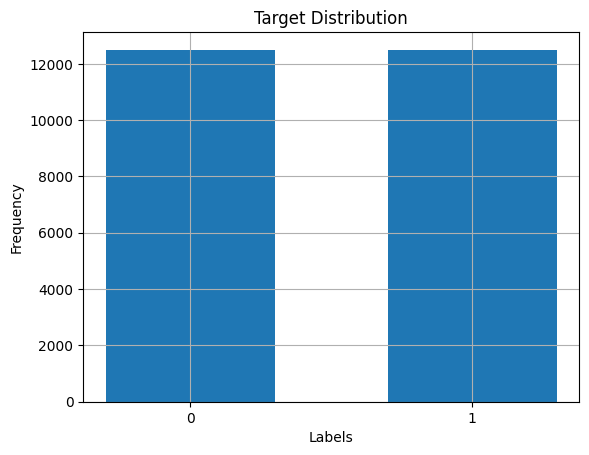

In [15]:
plt.bar(['0','1'],pd.Series(y_train).value_counts(),width=.6)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Target Distribution')
plt.grid()

Dimensionality reduction to check for patterns (e.g., clusters) in the data.

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_train_preprocessed)
X_train_2d = pca.transform(X_train_preprocessed)

No clear patterns.

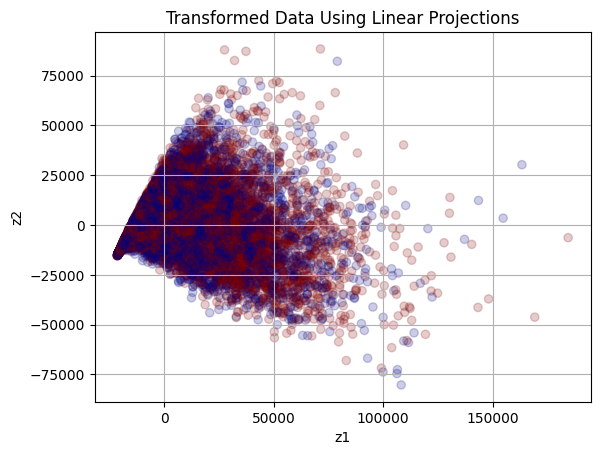

In [17]:
plt.scatter(X_train_2d[:,0],X_train_2d[:,1],c=y_train,cmap='jet',alpha=.2)
plt.xlabel('z1')
plt.ylabel('z2')
plt.title('Transformed Data Using Linear Projections')
plt.grid()

# Prepare the Data

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [19]:
def add_padding(X):
  # Add padding to reviews with a function, so that this preprocessing operation
  # can be added to a pipeline whose hyperparameters can be tuned.
  X_padded = np.zeros(shape=(X.shape[0],max_n),dtype='int64')
  for i in range(len(X)):
    review = X[i]
    X_padded[i,:len(review)] = review
  return X_padded


In [20]:
preprocessing_pipeline = Pipeline([
    ('pad',FunctionTransformer(add_padding)),
    ('delete',FunctionTransformer(np.delete,kw_args=dict(
        obj=0,axis=1)))
])

In [21]:
preprocessing_pipeline.transform(X_train)

array([[ 4078, 13406,     9, ...,     0,     0,     0],
       [   25,   128,    67, ...,     0,     0,     0],
       [   14,     9,    31, ...,     0,     0,     0],
       ...,
       [   13,    28,   610, ...,     0,     0,     0],
       [    6,   768,     7, ...,     0,     0,     0],
       [ 1945,    13,    67, ...,     0,     0,     0]])

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [23]:
tree_pipeline = Pipeline([
    ('preprocessing',preprocessing_pipeline),
    ('dt',DecisionTreeClassifier(random_state=0))
])

tree_hyperparameters = [
    {'dt__max_depth':[3,5,7],
     'dt__criterion' : ['gini','entropy','log_loss']}
]
rf_pipeline = Pipeline([
    ('preprocessing',preprocessing_pipeline),
    ('rf',RandomForestClassifier(random_state=0))
])

rf_hyperparameters = [
    {'rf__n_estimators':[10,100,1000],
     'rf__bootstrap' : [True,False]}
]

# Train Machine Learning Algorithms

In [24]:
from sklearn.model_selection import GridSearchCV

dt_grid_search = GridSearchCV(tree_pipeline,param_grid=tree_hyperparameters,cv=[(np.arange(20000),np.arange(20000,25000))])
dt_grid_search.fit(X_train,y_train)

GridSearchCV(cv=[(array([    0,     1,     2, ..., 19997, 19998, 19999]),
                  array([20000, 20001, 20002, ..., 24997, 24998, 24999]))],
             estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('pad',
                                                         FunctionTransformer(func=<function add_padding at 0x7a200bab2950>)),
                                                        ('delete',
                                                         FunctionTransformer(func=<function delete at 0x7a20b2b4aa70>,
                                                                             kw_args={'axis': 1,
                                                                                      'obj': 0}))])),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=0))]),
             param_grid=[{'dt__criterion': ['gini', 'entropy', 'log_loss'],
                          'dt__max_depth': [3, 5, 7]}])

In [26]:
dt_grid_search.score(X_test,y_test)

0.52292

In [25]:
rf_grid_search = GridSearchCV(rf_pipeline,param_grid=rf_hyperparameters,cv=[(np.arange(20000),np.arange(20000,25000))])
rf_grid_search.fit(X_train,y_train)

GridSearchCV(cv=[(array([    0,     1,     2, ..., 19997, 19998, 19999]),
                  array([20000, 20001, 20002, ..., 24997, 24998, 24999]))],
             estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('pad',
                                                         FunctionTransformer(func=<function add_padding at 0x7a200bab2950>)),
                                                        ('delete',
                                                         FunctionTransformer(func=<function delete at 0x7a20b2b4aa70>,
                                                                             kw_args={'axis': 1,
                                                                                      'obj': 0}))])),
                                       ('rf',
                                        RandomForestClassifier(random_state=0))]),
             param_grid=[{'rf__bootstrap': [True, False],
                          'rf__n_estimators': [10, 100, 1000]}])

In [34]:
rf_grid_search.score(X_test,y_test)

0.54572

In [35]:
rf_grid_search.best_params_

{'rf__bootstrap': True, 'rf__n_estimators': 1000}

# Compare with default hyperparameter values

In [28]:
dt = DecisionTreeClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)

In [29]:
default_tree_pipeline = Pipeline([
    ('preprocessing',preprocessing_pipeline),
    ('dt',DecisionTreeClassifier(random_state=0))
])

default_rf_pipeline = Pipeline([
    ('preprocessing',preprocessing_pipeline),
    ('rf',RandomForestClassifier(random_state=0))
])


In [30]:
default_tree_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('pad',
                                  FunctionTransformer(func=<function add_padding at 0x7a200bab2950>)),
                                 ('delete',
                                  FunctionTransformer(func=<function delete at 0x7a20b2b4aa70>,
                                                      kw_args={'axis': 1,
                                                               'obj': 0}))])),
                ('dt', DecisionTreeClassifier(random_state=0))])

In [32]:
default_tree_pipeline.score(X_test,y_test)

0.51148

In [31]:
default_rf_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('pad',
                                  FunctionTransformer(func=<function add_padding at 0x7a200bab2950>)),
                                 ('delete',
                                  FunctionTransformer(func=<function delete at 0x7a20b2b4aa70>,
                                                      kw_args={'axis': 1,
                                                               'obj': 0}))])),
                ('rf', RandomForestClassifier(random_state=0))])

In [33]:
default_rf_pipeline.score(X_test,y_test)

0.52768

# Feature Importance

In [41]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train_preprocessed,y_train)

RandomForestClassifier(random_state=0)

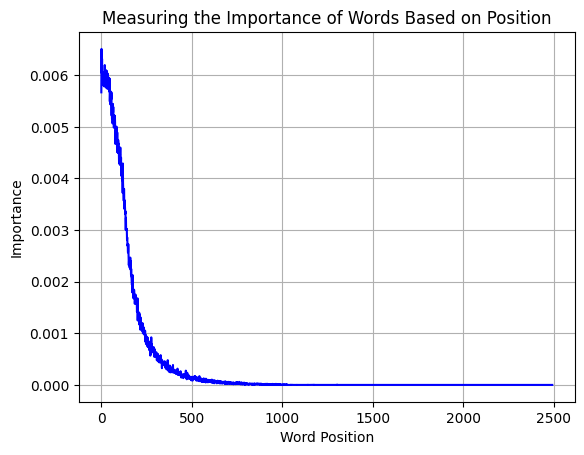

In [56]:
plt.plot(rf.feature_importances_,c='b')
plt.xlabel('Word Position')
plt.ylabel('Importance')
plt.title('Measuring the Importance of a Word Based on Position')
plt.grid()

# Analyzing What Types of Errors The Best Model Makes

In [57]:
y_pred = rf_grid_search.predict(X_test)

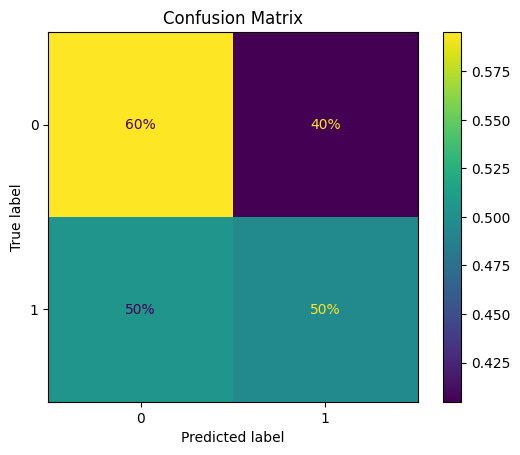

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,normalize='true',values_format='.0%')
plt.title('Confusion Matrix')
plt.show()